Rb Calculations (formerly known as Matrix Elements)

Preston Huft, May 2019.

https://docs.sympy.org/latest/modules/physics/wigner.html

sympy.physics.wigner.clebsch_gordan(j_1, j_2, j_3, m_1, m_2, m_3)[source], ⟨j1m1j2m2|j3m3⟩.
sympy.physics.wigner.wigner_3j(j_1, j_2, j_3, m_1, m_2, m_3)[source]
sympy.physics.wigner.wigner_6j(j_1, j_2, j_3, j_4, j_5, j_6, prec=None)[source]

In [491]:
%matplotlib notebook
from matplotlib import pyplot as plt
from sympy.physics.wigner import wigner_6j,wigner_3j,clebsch_gordan
from sympy import symbols,N,sympify,lambdify
from sympy import MatrixSymbol,MatAdd,MatMul,Identity as eye,Matrix,zeros
from sympy.utilities.iterables import flatten
import numpy as np
from numpy import transpose,inf
from numpy.linalg import eig
import math as m
from math import sqrt,pi

In [ ]:
## physical constants
ee = 1.60217662e-19 # [C]
a0 = 5.22e-11 # [m]
hbar = 1.0545718e-34 # [J s]
c = 299792458 # [m/s]
e0 = 8.85418782e-12 # [m^-3 kg^-1 s^4 A^2]
u0 = 1.25663706e-6 # [m kg s^-2 A^-2]
me = 9.10938356e-31 # [kg]
muB = 9.274e-24 # [J/T]

## Rb87 constants
I = 3/2 # nuclear spin
nu_hf = 6.83468261090429 # [GHz]
gS = 2.00023
gL = 1
gI = -0.000995

## reduced matrix elements from Steck
D2_MatElem = 3.584e-29 # <J=1/2||er||J'=3/2> [C*m]
D1_MatElem = 2.537e-29 # <J=1/2||er||J'=1/2> [C*m]

In [488]:
## methods

def hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,RME=None):
    """ Returns the matrix element <F,mF,J|T_q|F',mF',J'>. 
    
        RME is the reduced matrix element (just a number), which can be calculated
        externally and passed in to be a multiplier. If RME=None, the 
        matrix element is in units of [RME].
        
        I is the nuclear spin of the atom.
    """

    rme = 1
    if RME!=None:
        rme = RME

    ## From Mark's notes, eqs. A-50,51
    mat_elem = rme*pow(-1,F+JJ+1+I)*sqrt((2*F+1)*(2*JJ+1)) \
                *wigner_6j(J,I,F,FF,1,JJ) \
                *clebsch_gordan(1,F,FF,q,mF,mFF)
    
    return mat_elem

def eff_rabi(O,D):
    """ the effective rabi frequency, given a rabi freq O, and 
        detuning D from the transition frequency"""
    return sqrt(O**2+D**2)

def jmbasis(jlist):
    """ returns a numpy array of basis vectors {|J,mJ>} given a list of 
        J vals"""
    basis = np.empty(sum([2*j+1 for j in jlist]),list)
    i = 0
    for j in jlist:
        for m in range(-j,j+1):
            basis[i] = [j,m]
            i+=1 
    return basis

def cc(z):
    return np.conj(z)

def radToTHz(w):
    return w/(2*pi*1e12)

def radToGHz(w):
    return w/(2*pi*1e9)

def radToMhz(w):
    return w/(2*pi*1e6)

def radTokHz(w):
    return w/(2*pi*1e3)

def JToeV(u):
    global ee
    return u/ee

def eVToJ(u):
    global ee
    return u*ee

def GHzToeV(nu):
    global hbar
    return JToeV(2*pi*hbar*nu*1e9)

def eVToGHz(u):
    global hbar
    return eVToJ(u)/(2*pi*hbar*1e9)


# def alpha(w_ab,w,RME,I):
#     """ the polarizability of a two-level atom in an AC electric field
#     """
#     return 

In [179]:
###################################################################
# calculate 2 photon Rabi frequency for the ground state hyperfine 
# Raman transition
###################################################################

P = 3.5e-6 # [W] light power at experiment cell
a = 6e-6 # [m]
b = 8e-6 # [m], in y direction
A = a*b*pi # area at beam waist 
E0 = sqrt(4*P/(c*e0*A)) # the electric field amplitude
d = 2*pi*4.5e10 # [Hz] Single photon detuning

#       hf_matrix_elem(F,mF,J,q,FF,mFF,JJ,I,RME=None):
O1 = E0*hf_matrix_elem(2,0,1/2,1,2,1,3/2,I,D2_MatElem)/hbar
O2 = E0*hf_matrix_elem(1,0,1/2,1,2,1,3/2,I,D2_MatElem)/hbar

# Ignoring a.c. stark shifts, etc:

# O1 /= 1e9 # [GHz]
# O2 /= 1e9 #
# print(N(O1),N(O2))

O = N(abs(O1*O2/(2*d))/1e3)/(2*pi) # [kHz]
print(f"Two-photon Rabi frequency = 2*pi*{O:.2f} kHz")

Two-photon Rabi frequency = 2*pi*284.24 kHz


In [180]:
## for the raman pulse notebook
o1 = hf_matrix_elem(2,0,1/2,1,2,1,3/2,I,D2_MatElem)
o2 = hf_matrix_elem(1,0,1/2,1,2,1,3/2,I,D2_MatElem)
print(N(o1),N(o2))

-1.79200000000000e-29 1.79200000000000e-29


In [181]:
###################################################################
# Differential AC Stark Shifts
###################################################################

def scalar_ls(w_ab,w,I,RME=None):
    """ the scalar AC Stark shift, or light shift, seen by a two 
        level atom in an oscillating electric field.
        w_ab is the freq difference between a,b
        w is the applied light frequency
        I is the intensity of the light 
        RME is the reduced matrix element <J||r||J'>. Careful! This
        does not include the electron charge.
    """
    
    if RME is None:
        RME = 1 # the light shift is now in units of the RME
    
    return -(ee**2)*w_ab*cc(RME)*RME*I/(2*hbar*(w_ab**2-w**2))

In [182]:
# The D2 line differential light shift of Rb87 in a far-off-resonance
# trap (FORT)

w0 = 2*pi*384.2304844685e12 # D2 line transition frequency
wFORT = 2*pi*c/(1064e-9)

waist = 2.5e-6 # gaussian waist of the FORT
P = .5 # [W] approx at center site (e.g. during PGC phase)
Int = P/(pi*waist**2)

In [183]:
radToTHz(wFORT)

281.7598289473684

In [502]:
###################################################################
# HF Zeeman Shifts
###################################################################

# Chris mentioned the quadrupole term.. I think I/Mark dropped that 

def gF_fn(F,J,I,gJ,gI):
    """ Returns the F lande g factor """
    
    return (gJ*(F*(F+1)+J*(J+1)-I*(I+1))
            +gI*(F*(F+1)-J*(J+1)+I*(I+1)))/(2*F*(F+1))

def gJ_fn(J,L,S,gL,gS):
    """ Returns the J lande g factor """

    return (gL*(J*(J+1)+L*(L+1)-S*(S+1)) 
            +gS*(J*(J+1)-L*(L+1)+S*(S+1)))/(2*J*(J+1))

def hf_zeeman(states,gJ,gI,Bz=None,units=None):
    """ From Mark's notes for the general hf Zeeman matrix elements. Units
        are determined by UB. Could implement decorator function to change
        units."""
    global muB # Bohr magneton
    UB = symbols('U_B') # assume symbolic B field P.E. for now

    if Bz is not None:
        UB = muB*Bz# magnetic field potential energy

    if units == 'UB':
        UB = 1
        
    I,J,F,mF,FF,mFF = states
    q = 0 # assume B = Bz for now
    
    elem = 0
    if mF == mFF:
        elem += N(clebsch_gordan(F,1,FF,mF,q,mFF) \
                *sqrt(2*F+1)*(-1)**(1+J+I) \
                *(gJ*(-1)**F*sqrt(J*(J+1)*(2*J+1)) \
                *wigner_6j(J,I,F,FF,1,J) \
                +gI*(-1)**FF*sqrt(I*(I+1)*(2*I+1)) \
                *wigner_6j(I,J,F,FF,1,I))) 
        # N() is used to ensure diagnolization doesn't get tripped up
    
    return UB*elem

# Rb87 ground state 5s1/2:
L = 0; S = 1/2; J = 1/2;
Flist = [2,1] # F = I + J
E_hf = GHzToeV(nu_hf)

gJ = gJ_fn(J,L,S,gL,gS)

Bzlist = np.linspace(0,.5,30)

E_hf = GHzToeV(nu_hf) # assign numeric value to ease diagonalization (?)

# Rb Hamiltonian for HF ground states in {|F,mF>} basis
H_a = E_hf*np.array([[1,0,0,0,0,0,0,0],
                     [0,1,0,0,0,0,0,0],
                     [0,0,1,0,0,0,0,0],
                     [0,0,0,1,0,0,0,0],
                     [0,0,0,0,1,0,0,0],
                     [0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0],
                     [0,0,0,0,0,0,0,0]],object)

# Zeeman Hamiltonian for B = Bz
H_Zz = np.empty((8,8),object)
basis = jmbasis(Flist)
for i,state_i in enumerate(basis):
        F,mF = state_i
        for j,state_j in enumerate(basis):
            FF,mFF = state_j
            states = [I,J,F,mF,FF,mFF]
            try:
                H_Zz[i,j] = hf_zeeman(states,gJ,gI)
            except:
                print("Failed: %s" % states)

# Diagonalize the full Hamiltonian
H = Matrix(H_a + H_Zz)
P,D = H.diagonalize()
evals = [D[i,i] for i in range(0,len(basis))]

# The energies as a function of magnetic P.E.
shifts = lambdify('U_B',evals)

zshifts = np.empty((len(Bzlist),len(basis)))
for i,Bz in enumerate(Bzlist):
    # make sure units of U_B same as E_hf then convert the whole shift
    zshifts[i] = [eVToGHz(x) for x in shifts(JToeV(uB*Bz))] 
    
# arranged the shifts by state, not B value
zshifts = transpose(zshifts) 

<IPython.core.display.Javascript object>


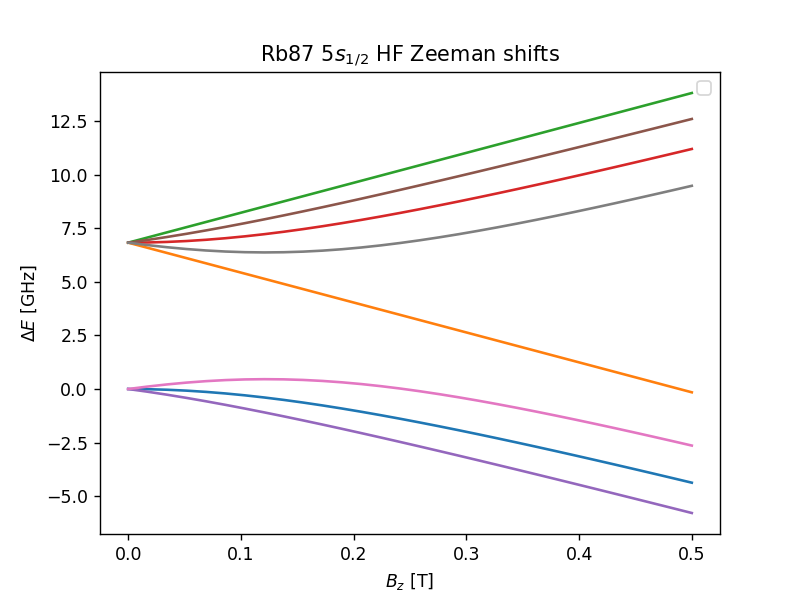

No handles with labels found to put in legend.


In [504]:
# initialize the figure and plot
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Rb87 $5s_{1/2}$ HF Zeeman shifts")
ax.set_xlabel("$B_z$ [T]")
ax.set_ylabel("$\Delta E$ [GHz]")

for state,shift in zip(basis,zshifts):
    F,mF = state
    ax.plot(Bzlist,shift) #,label=f"|{F},{mF}>") # shifts not in same order as basis... hmm 🤔
ax.legend(loc='upper right')
plt.show()